
# Transfer Learning con VGG16 en CIFAR-10 (PyTorch)



In [1]:

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models

import matplotlib.pyplot as plt
import numpy as np
import time
from copy import deepcopy


In [2]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

## 1. Carga y preparación del dataset CIFAR-10

In [3]:

# CIFAR-10: 10 clases, imágenes 32x32. VGG16 espera 224x224 y normalización de ImageNet.

imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])

train_dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=train_transform)
test_dataset = datasets.CIFAR10(root="./data", train=False, download=True, transform=test_transform)

batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

class_names = train_dataset.classes
num_classes = len(class_names)
num_classes


10

## 2. Funciones auxiliares

In [4]:

def evaluate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data).item()
            total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = running_corrects / total
    return epoch_loss, epoch_acc


def train_model(model, criterion, optimizer, train_loader, val_loader, device, num_epochs=5, scheduler=None):
    history = {
        "train_loss": [], "train_acc": [],
        "val_loss": [], "val_acc": []
    }
    best_model_wts = deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_corrects = 0
        total = 0

        start = time.time()
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data).item()
            total += labels.size(0)

        train_loss = running_loss / total
        train_acc = running_corrects / total

        val_loss, val_acc = evaluate(model, val_loader, criterion, device)

        if scheduler is not None:
            scheduler.step()

        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = deepcopy(model.state_dict())

        end = time.time()
        print(f"Epoch {epoch+1}/{num_epochs} - {end - start:.1f}s | "
              f"Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")

    model.load_state_dict(best_model_wts)
    return model, history


## 3. Cargar VGG16 preentrenado y adaptar la última capa

In [5]:

def get_vgg16(num_classes, pretrained=True):
    model = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1 if pretrained else None)
    # VGG16 -> classifier is a Sequential, last layer is index 6
    in_features = model.classifier[6].in_features
    model.classifier[6] = nn.Linear(in_features, num_classes)
    return model


## 4. A: Evaluación sin entrenamiento adicional

In [6]:

expA_model = get_vgg16(num_classes=num_classes, pretrained=True).to(device)
criterion = nn.CrossEntropyLoss()

# NO entrenamos. Solo evaluamos en test.
test_loss_A, test_acc_A = evaluate(expA_model, test_loader, criterion, device)

print(f"parte A Test Loss: {test_loss_A:.4f} | Test Acc: {test_acc_A:.4f}")


parte A Test Loss: 2.3427 | Test Acc: 0.0992


## 5. B: Feature Extraction (congelar convolucionales, entrenar solo la FC)

In [7]:

expB_model = get_vgg16(num_classes=num_classes, pretrained=True)

# congelar todas las capas convolucionales (features)
for param in expB_model.features.parameters():
    param.requires_grad = False

expB_model = expB_model.to(device)

criterion = nn.CrossEntropyLoss()
# solo se entrenan los parámetros que requieren grad
optimizer_B = optim.Adam(filter(lambda p: p.requires_grad, expB_model.parameters()), lr=1e-3)

num_epochs_B = 5
expB_model, history_B = train_model(expB_model, criterion, optimizer_B,
                                    train_loader, test_loader, device,
                                    num_epochs=num_epochs_B)

test_loss_B, test_acc_B = evaluate(expB_model, test_loader, criterion, device)
print(f"B Test Loss: {test_loss_B:.4f} | Test Acc: {test_acc_B:.4f}")


Epoch 1/5 - 309.0s | Train Loss: 0.7152 Acc: 0.7763 | Val Loss: 0.4722 Acc: 0.8477
Epoch 2/5 - 308.6s | Train Loss: 0.5177 Acc: 0.8458 | Val Loss: 0.4965 Acc: 0.8413
Epoch 3/5 - 308.7s | Train Loss: 0.4304 Acc: 0.8761 | Val Loss: 0.4602 Acc: 0.8604
Epoch 4/5 - 308.7s | Train Loss: 0.3887 Acc: 0.8929 | Val Loss: 0.5088 Acc: 0.8618
Epoch 5/5 - 308.8s | Train Loss: 0.3560 Acc: 0.9045 | Val Loss: 0.4518 Acc: 0.8684
B Test Loss: 0.4518 | Test Acc: 0.8684


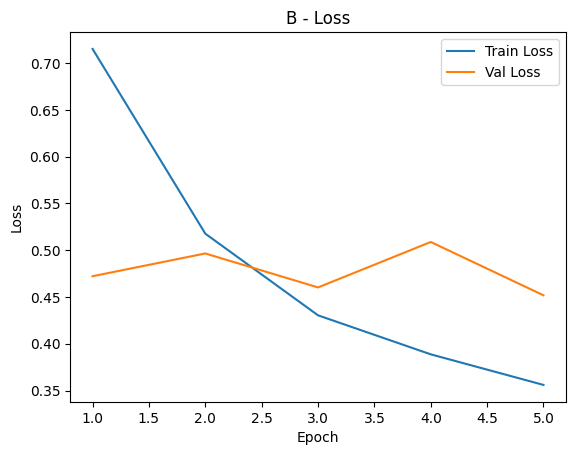

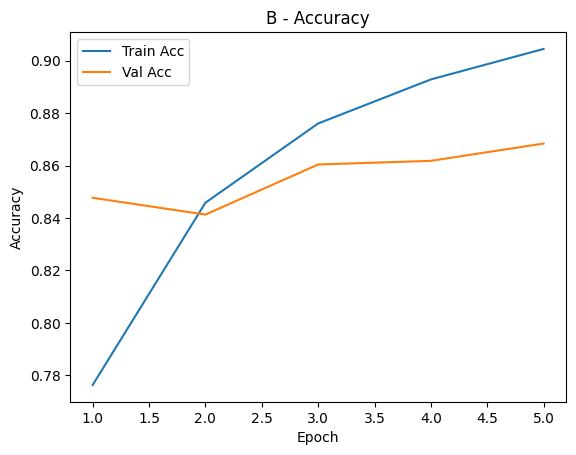

In [8]:

# Graficar curvas B
epochs_B = range(1, len(history_B["train_loss"]) + 1)

plt.figure()
plt.plot(epochs_B, history_B["train_loss"], label="Train Loss")
plt.plot(epochs_B, history_B["val_loss"], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("B - Loss")
plt.legend()
plt.show()

plt.figure()
plt.plot(epochs_B, history_B["train_acc"], label="Train Acc")
plt.plot(epochs_B, history_B["val_acc"], label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("B - Accuracy")
plt.legend()
plt.show()


## 6. C: Fine-Tuning (descongelar todo el modelo)

In [9]:

expC_model = get_vgg16(num_classes=num_classes, pretrained=True).to(device)

criterion = nn.CrossEntropyLoss()
# LR pequeño para todo el modelo
optimizer_C = optim.Adam(expC_model.parameters(), lr=1e-4)
scheduler_C = optim.lr_scheduler.StepLR(optimizer_C, step_size=3, gamma=0.1)

num_epochs_C = 5
expC_model, history_C = train_model(expC_model, criterion, optimizer_C,
                                    train_loader, test_loader, device,
                                    num_epochs=num_epochs_C,
                                    scheduler=scheduler_C)

test_loss_C, test_acc_C = evaluate(expC_model, test_loader, criterion, device)
print(f"C Test Loss: {test_loss_C:.4f} | Test Acc: {test_acc_C:.4f}")


Epoch 1/5 - 750.7s | Train Loss: 0.4400 Acc: 0.8502 | Val Loss: 0.2775 Acc: 0.9087
Epoch 2/5 - 749.7s | Train Loss: 0.1932 Acc: 0.9346 | Val Loss: 0.2523 Acc: 0.9194
Epoch 3/5 - 748.7s | Train Loss: 0.1218 Acc: 0.9588 | Val Loss: 0.2747 Acc: 0.9128
Epoch 4/5 - 748.8s | Train Loss: 0.0226 Acc: 0.9927 | Val Loss: 0.2159 Acc: 0.9442
Epoch 5/5 - 748.5s | Train Loss: 0.0056 Acc: 0.9988 | Val Loss: 0.2482 Acc: 0.9440
C Test Loss: 0.2159 | Test Acc: 0.9442


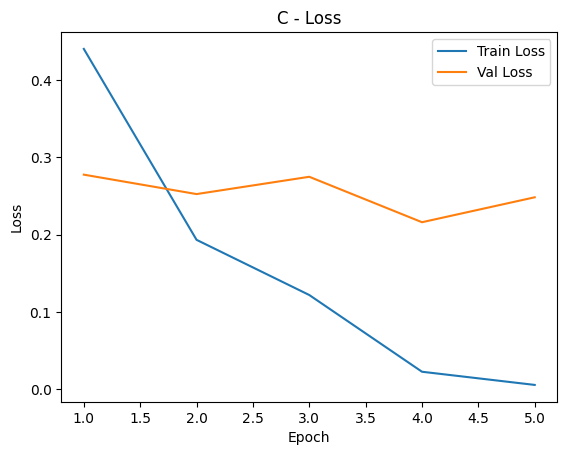

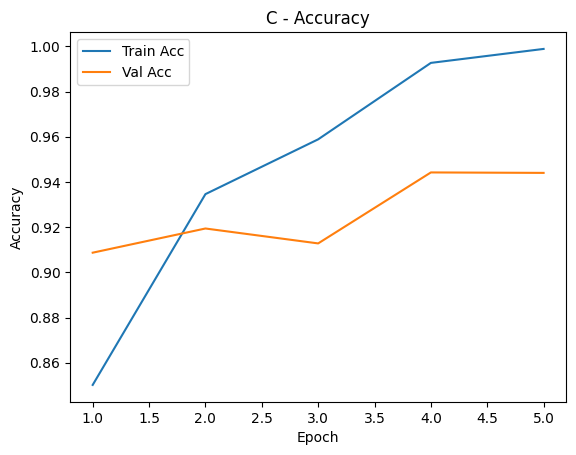

In [10]:

# Graficar curvas C
epochs_C = range(1, len(history_C["train_loss"]) + 1)

plt.figure()
plt.plot(epochs_C, history_C["train_loss"], label="Train Loss")
plt.plot(epochs_C, history_C["val_loss"], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("C - Loss")
plt.legend()
plt.show()

plt.figure()
plt.plot(epochs_C, history_C["train_acc"], label="Train Acc")
plt.plot(epochs_C, history_C["val_acc"], label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("C - Accuracy")
plt.legend()
plt.show()


## 7. Tabla comparativa de resultados

In [11]:

import pandas as pd

results = {
    "Experimento": ["A - sin entrenamiento", "B - feature extraction", "C - fine-tuning"],
    "Train Acc": [None,
                  history_B["train_acc"][-1] if "history_B" in locals() else None,
                  history_C["train_acc"][-1] if "history_C" in locals() else None],
    "Train Loss": [None,
                   history_B["train_loss"][-1] if "history_B" in locals() else None,
                   history_C["train_loss"][-1] if "history_C" in locals() else None],
    "Test Acc": [test_acc_A, test_acc_B, test_acc_C],
    "Test Loss": [test_loss_A, test_loss_B, test_loss_C]
}

df_results = pd.DataFrame(results)
df_results


,Experimento,Train Acc,Train Loss,Test Acc,Test Loss
0,A - sin entrenamiento,NaN,NaN,0.0992,2.342727
1,B - feature extraction,0.90450,0.355988,0.8684,0.451772
2,C - fine-tuning,0.99884,0.005551,0.9442,0.215949
